In [1]:
import torch
from torch import nn, optim
import mltools

In [2]:
device=torch.device('cuda')
train_iter, val_iter, test_iter = mltools.mnist(batch_size=1000)  # 获取训练集、验证集和测试集
model = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10))  # 设置模型结构
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)
ml = mltools.SupervisedLearning('mlp')
ml.add_model(model)

In [3]:
ml.load('2025-06-30-13-56-17-mlp')

2025-06-30 14:10:40,101 - WARNING: num_epochs is 2, but it is less than 2, so it will not be trained
2025-06-30 14:10:40,102 - INFO: train loss 0.687, val loss 0.548, val acc 0.864, 4.4 sec/epoch on cuda


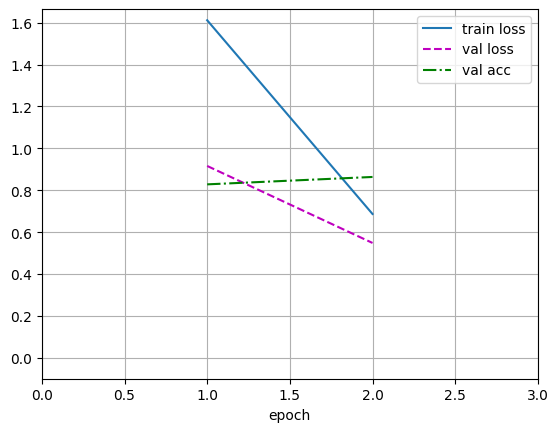

In [4]:
@ml.trainer
def train(num_epochs):
    '''迭代训练'''
    for _ in range(1, num_epochs + 1):
        ml.timer.start()
        # 计算训练集
        metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
        model.train()  # 训练模式
        for x, y in train_iter:
            x = x.to(device)  # 转换x
            y = y.to(device)  # 转换y
            y_train = model(x)  # 计算模型
            train_loss = loss(y_train, y)  # 计算训练损失

            # 梯度更新
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            metric_train.add(train_loss * y.numel(), y.numel())
        ml.recorder[0].append(metric_train[0] / metric_train[1])
        ml.timer.stop()
        # 计算验证集
        metric_val = mltools.Accumulator(3)  # 累加器：(val_loss, val_acc, val_size)
        model.eval()  # 验证模式
        with torch.no_grad():
            for x, y in val_iter:
                x = x.to(device)  # 转换x
                y = y.to(device)  # 转换y
                y_val = model(x)  # 计算模型
                val_loss = loss(y_val, y)  # 计算验证损失
                val_pred = y_val.argmax(dim=1)  # 计算预测值
                val_acc = (val_pred == y).sum()  # 计算验证准确率
                metric_val.add(val_loss * y.numel(), val_acc, y.numel())
        ml.recorder[1].append(metric_val[0] / metric_val[2])
        ml.recorder[2].append(metric_val[1] / metric_val[2])
        # 打印输出值
        ml.logger.info(f'train loss {ml.recorder[0][-1]:.3f}, val loss {ml.recorder[1][-1]:.3f}, val acc {ml.recorder[2][-1]:.3f}, {ml.timer.avg():.1f} sec/epoch on {str(device)}')
        ml.animator.show(ml.recorder.data)  # 显示动画
    else:
        # 打印输出值
        ml.logger.info(f'train loss {ml.recorder[0][-1]:.3f}, val loss {ml.recorder[1][-1]:.3f}, val acc {ml.recorder[2][-1]:.3f}, {ml.timer.avg():.1f} sec/epoch on {str(device)}')


train(num_epochs=2)

In [5]:
# 测试模型
model.eval()
metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
with torch.no_grad():
    for x, y in test_iter:
        x = x.to(device)  # 转换x
        y = y.to(device)  # 转换y
        y_test = model(x)  # 计算模型
        test_pred = y_test.argmax(dim=1)  # 计算准确率
        test_acc = (test_pred == y).sum()  # 计算测试准确率
        metric.add(test_acc, y.numel())
ml.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

2025-06-30 14:10:41,158 - INFO: test acc 0.874


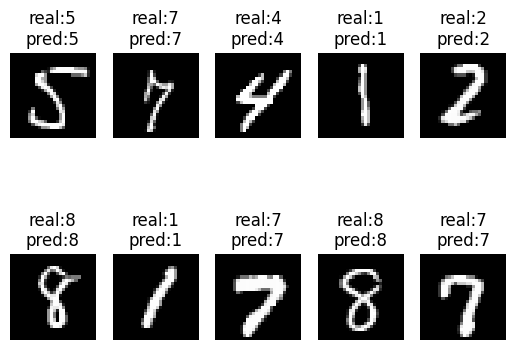

In [6]:
# 预测模型
x, y = next(iter(test_iter))  # 从测试中取一个批量
x = x[:10].to(device)
y = y[:10].to(device)
y_pred = model(x)  # 计算模型
y_pred = y_pred.argmax(dim=1)  # 计算预测
labels = [f'real:{y[index]}\npred:{y_pred[index]}' for index in range(y.numel())]
mltools.images(x.squeeze(1), labels, shape=(2, 5))